###Overview

This notebook is a variation of notebook 1, producing the datasets for the candidate model.\
Our variation tries to incorporate information about transitions from genre to genre, considering the viewing history to be a Markov chain of order 1.\
We calculate the trnansition probabilities from genre to genre for each user.\
The last movie of each sample sequence can be used to predict the target by producing a vector of expected genre distribution.\
When the model compares candidates, their genre representation as a vector of norm 1 is multiplied with the predicted distribution and added to the dot product of the basic model.

This notebook takes care of calculating the transition metrices and adding the predicted genre distribution to each sample according to the kast movie in the viewing history.

The next notebook will add the genres information to the predictive dot prodect.


In [7]:
# basic
import os 
import sys
import math
from time import time
import zipfile
import requests
import pickle

# general
import warnings
import numpy as np
# import scipy as sp
import pandas as pd
# import scipy.sparse as sp

# visual
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# notebook
from IPython.display import display, HTML
from tqdm import tqdm
import copy

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
warnings.filterwarnings('ignore')

**Downloading files:**

In [10]:
url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'
zip_name = 'ml-1m.zip'
data_dir = 'ml-1m/'

r = requests.get(url, allow_redirects=True)
open(zip_name, 'wb').write(r.content)

with zipfile.ZipFile(zip_name,"r") as zip_ref:
    zip_ref.extractall()

In [11]:
cols_item = ['movie id', 'movie name', 'genres']             
df_items = pd.read_csv(data_dir + 'movies.dat', delimiter='::', header=None, names=cols_item, encoding = 'ISO-8859-1')
df_items.shape

(3883, 3)

In [12]:
genres_list = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
genres_mapping = dict(zip(genres_list, np.arange(len(genres_list))))

In [13]:
def separate_genres(genres):
  item_genres = genres.split('|')
  genres_features = np.zeros(len(genres_list))
  for g in item_genres:
    genres_features[genres_mapping[g]] = 1
  return genres_features

In [14]:
g_features = df_items['genres'].apply(separate_genres)

In [15]:
df_items['genres features'] = g_features

In [10]:
df_items.head()

,movie id,movie name,genres,genres features
0,1,Toy Story (1995),Animation|Children's|Comedy,"[0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
1,2,Jumanji (1995),Adventure|Children's|Fantasy,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
4,5,Father of the Bride Part II (1995),Comedy,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


**Reading ratings file:**

In [16]:
cols_data = ['user_id','item_id','rating','timestamp']
df_ratings = pd.read_csv(data_dir + 'ratings.dat',delimiter='::', header=None,names=cols_data)

n_full_samples = df_ratings.shape[0]
unique_users_test = df_ratings['user_id'].nunique()
n_items = df_ratings['item_id'].max() + 1 #starts at 1
print(f'There are a total of {n_full_samples} samples in the full dataset, belonging to {unique_users_test} distinct users')

There are a total of 1000209 samples in the full dataset, belonging to 6040 distinct users


In [11]:
df_ratings.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


**Sorting events by user and timestamp and extracting sample age**

In [17]:
df_ratings_timestamp_sorted = df_ratings.groupby(['user_id']).apply(lambda x: x.sort_values(['timestamp'])).reset_index(drop=True)

In [18]:
now = df_ratings_timestamp_sorted['timestamp'].max()
time_range = now - df_ratings_timestamp_sorted['timestamp'].min()
df_ratings_timestamp_sorted['example age'] = (now - df_ratings_timestamp_sorted['timestamp'])/time_range
df_ratings_timestamp_sorted['example age sq'] = df_ratings_timestamp_sorted['example age']**2

In [19]:
df_ratings_timestamp_sorted.head()

,user_id,item_id,rating,timestamp,example age,example age sq
0,1,3186,4,978300019,0.759377,0.576653
1,1,1721,4,978300055,0.759376,0.576653
2,1,1022,5,978300055,0.759376,0.576653
3,1,1270,5,978300055,0.759376,0.576653
4,1,2340,3,978300103,0.759376,0.576652


###Genre transition probabilities

In [15]:
users_transition = {}
num_users = 6040
for u in range(num_users):
  df_user = df_ratings_timestamp_sorted[df_ratings_timestamp_sorted['user_id'] == u+1]
  item_ids = df_user['item_id'].values
  transition_matrix = np.zeros((len(genres_list), len(genres_list)))
  for i in range(len(item_ids)-1):
    current_genres = df_items.loc[df_items['movie id'] == item_ids[i]]['genres features'].values[0]
    next_genres = df_items.loc[df_items['movie id'] == item_ids[i+1]]['genres features'].values[0]
    transition_matrix += np.outer(current_genres, next_genres)
    row_sum_norm = np.sqrt(np.sum(transition_matrix**2, axis = 1))
    row_sum_norm[row_sum_norm == 0] = 1
    end_matrix = transition_matrix/row_sum_norm[:, np.newaxis]
    users_transition[u+1] = end_matrix

In [16]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/transition_probabilities'
# with open(path, 'wb') as f:
#   pickle.dump((users_transition), f)

In [20]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/transition_probabilities'
# with open(path , 'rb') as f:
#   (users_transition) = pickle.load(f)

###Previous watches processing

**Extracting previous watches, relevant to each movie.**\
As in the paper, we extract a history of 50 last watches.\
To be able to process this in batches later, the buffer is padded with 0 for samples with less than 50 previous watches. This creates all lengths of effective history up to a cold start new user.\
Although users with many ratings will have more samples, this is corrected later by sampling the same number of samples per user.

In [21]:
max_len = 50
prev = []
num_users = 6040
for u in range(num_users):
  df_user = df_ratings_timestamp_sorted[df_ratings_timestamp_sorted['user_id'] == u+1]
  item_ids = df_user['item_id'].values
  for ind, i in enumerate(item_ids):
    if ind < max_len:
      item_list = np.pad(item_ids[:ind], (max_len-ind, 0), 'constant', constant_values=(0))
    else:
      item_list = item_ids[ind-max_len:ind] #50 last
    prev.append(item_list)

In [22]:
df_ratings_timestamp_sorted['previous watches'] = prev

In [19]:
df_ratings_timestamp_sorted.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches
0,1,3186,4,978300019,0.759377,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,1721,4,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1,1022,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1,1270,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,1,2340,3,978300103,0.759376,0.576652,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


**Extracting user data and processing features**\
Age catagory is mapped from code to class to be embedded later.\
Occupation feature is already mapped to a fix range and so doesn't require additional processing.\
Gender is converted to binary 0/1\
We can see that zipcode is not usefull without further information, since there are 3439 unique codes out of 6400 users. To use this information we would have to make some assumptions on how to group these codes together.

In [23]:
cols_user = ['user_id', 'gender', 'age', 'occupation', 'zip code']
df_users = pd.read_csv(data_dir + 'users.dat', delimiter='::', header=None, names=cols_user)

In [21]:
df_users.head()

,user_id,gender,age,occupation,zip code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [24]:
gender_mapping = {'F' : 1, 'M' : 0}
df_users['gender'] = df_users['gender'].apply(lambda x: gender_mapping[x])

In [25]:
ages = np.sort(df_users['age'].unique())
age_mapping = dict(zip(ages, np.arange(len(ages))))
df_users['age'] = df_users['age'].apply(lambda x: age_mapping[x])

In [73]:
age_mapping

{1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}

In [ ]:
# occupation already has the correct maping
# occ = np.sort(df_users['occupation'].unique())
# occ_mapping = dict(zip(occ, np.arange(len(occ))))

In [ ]:
#not using zipcode, since most are unique
zip_codes = np.sort(df_users['zip code'].unique())
# zip_code_mapping = dict(zip(zip_codes, np.arange(len(zip_codes))))
len(zip_codes)

3439

In [26]:
df_features = df_ratings_timestamp_sorted.merge(df_users.drop(['zip code'], axis=1), how='inner', on='user_id')

In [25]:
df_features.head(5)

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation
0,1,3186,4,978300019,0.759377,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
1,1,1721,4,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
2,1,1022,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
3,1,1270,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
4,1,2340,3,978300103,0.759376,0.576652,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10


**Put aside test and validation**\
From each user, we extract the sample of the last timestamp as the test set.\
We take the second to last sample for the validation set.\
There are many considerations in choosing the validation set. Here we choose samples with watch history similar to that of the test set. On one hand, the training set does not have this very similar history, which is better for generalization. On the other hand we may overfit a little when choosing hyperparameters (even though the target item ID is not the same...).\
We are also ensuring we choose a sample with long enough history which will represent most cases.\
I believe that this is still the best choice.


In [27]:
df_test = df_features.groupby(['user_id']).tail(1)
test_indices = df_test.index.to_list()
df_features.drop(index = test_indices, inplace = True)

df_val = df_features.groupby(['user_id']).tail(1) #we consider to choose validation at random
val_indices = df_val.index.to_list()
df_features.drop(index = val_indices, inplace = True)

In [28]:
df_test.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation
52,1,48,5,978824351,0.753535,0.567815,"[1022, 1270, 2340, 1836, 3408, 1207, 2804, 720...",1,0,10
181,2,1917,3,978300174,0.759375,0.576651,"[356, 3809, 3108, 1265, 2571, 457, 2028, 589, ...",0,6,16
232,3,2081,4,978298504,0.759394,0.576679,"[593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...",0,2,15
253,4,1954,5,978294282,0.759441,0.576750,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,7
451,5,288,2,978246585,0.759972,0.577558,"[1721, 1729, 733, 2952, 2353, 509, 224, 357, 1...",0,2,20


In [28]:
df_features.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation
0,1,3186,4,978300019,0.759377,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
1,1,1721,4,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
2,1,1022,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
3,1,1270,5,978300055,0.759376,0.576653,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
4,1,2340,3,978300103,0.759376,0.576652,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10


**Sampling**\
As in the paper, we would like to sample a fixed number of samples for each user to not let users with rich history affect the results disproportionately.\
For users with short history, taking the same number of samples means repeating the same sample many times.\
To decide how many samples are reasonable to take for each user, we can look at the distribution of ratings per user (below). Considering the above, it was decided to sample 50 samples from each user, representing about 28% of users with less movies in history.

Mean number of ratings is 163.5975165562914
Number of users with less than 50 samples 0.28671875%


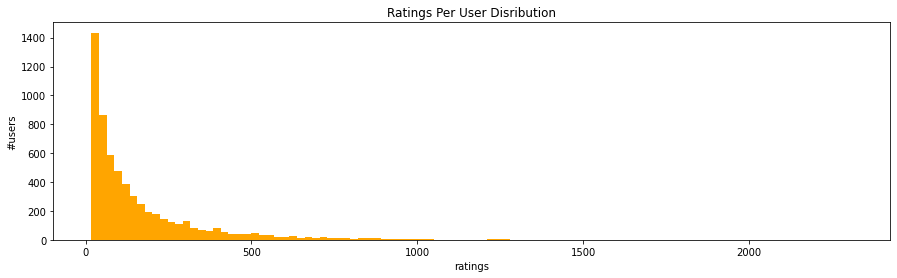

In [ ]:
# Justifying the chosen n for sample size
counts = df_features.groupby('user_id').size()
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
c=counts.plot.hist(ax=ax, color='orange', bins = 100)
ax.set_title('Ratings Per User Disribution')
ax.set_xlabel('ratings')
ax.set_ylabel('#users')
print(f'Mean number of ratings is {counts.mean()}')
print(f'Number of users with less than 50 samples {(counts < 50).sum()/6400}%')

In [29]:
n_samples_per_user = 50
#should use manual random seed for same results...
np.random.seed(42)
df_features_sampled = df_features.groupby(['user_id']).sample(n_samples_per_user, replace=True)
df_features_sampled.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation
38,1,594,4,978302268,0.759352,0.576615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3186, 172...",1,0,10
28,1,2762,4,978302091,0.759354,0.576618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
14,1,2692,4,978301570,0.759360,0.576627,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10
42,1,1,5,978824268,0.753536,0.567816,"[0, 0, 0, 0, 0, 0, 0, 0, 3186, 1721, 1022, 127...",1,0,10
7,1,1207,4,978300719,0.759369,0.576641,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10


In [34]:
def add_predicted_transition(df):
  last_predicted_transitions = []
  for i, row in df.iterrows():
    user_id = row['user_id']
    user_last_view = row['previous watches'][-1]
    if user_last_view>0:
      last_genres = df_items.loc[df_items['movie id'] == user_last_view]['genres features'].values[0]
      genres_indices = np.nonzero(last_genres)
      sum_genres = last_genres.sum()
      pred_trans = users_transition[user_id][genres_indices]
      sum_components = pred_trans.sum(axis = 0)
      norm = np.sqrt((sum_components**2).sum())
      if norm > 0:
        last_predicted_transitions.append(sum_components/norm)
      else:
        last_predicted_transitions.append(np.zeros(len(genres_list)))
    else:
      last_predicted_transitions.append(np.zeros(len(genres_list)))
  return last_predicted_transitions

In [35]:
last_predicted_transitions = add_predicted_transition(df_features_sampled)
df_features_sampled['pred_trans'] = last_predicted_transitions

In [38]:
last_predicted_transitions = add_predicted_transition(df_test)
df_test['pred_trans'] = last_predicted_transitions

In [39]:
last_predicted_transitions = add_predicted_transition(df_val)
df_val['pred_trans'] = last_predicted_transitions

In [34]:
df_features_sampled.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation,pred_trans
38,1,594,4,978302268,0.759352,0.576615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3186, 172...",1,0,10,"[0.034752402342845795, 0.134173515769265, 0.39..."
28,1,2762,4,978302091,0.759354,0.576618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.06917144638660747, 0.15561863336409476, 0.3..."
14,1,2692,4,978301570,0.759360,0.576627,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.3618262707230165, 0.02305714879553582, 0.26..."
42,1,1,5,978824268,0.753536,0.567816,"[0, 0, 0, 0, 0, 0, 0, 0, 3186, 1721, 1022, 127...",1,0,10,"[0.1037571695799112, 0.03458572319330373, 0.45..."
7,1,1207,4,978300719,0.759369,0.576641,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.2075143391598224, 0.06917144638660747, 0.41..."


In [35]:
df_val.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation,pred_trans
51,1,1566,4,978824330,0.753535,0.567815,"[1721, 1022, 1270, 2340, 1836, 3408, 1207, 280...",1,0,10,"[0.0, 0.05335078579018945, 0.5335078579018946,..."
180,2,1544,4,978300174,0.759375,0.576651,"[2359, 356, 3809, 3108, 1265, 2571, 457, 2028,...",0,6,16,"[0.6651923882712844, 0.22044719013118996, 0.0,..."
231,3,104,4,978298486,0.759394,0.576679,"[0, 593, 2858, 3534, 1968, 1961, 1431, 1266, 1...",0,2,15,"[0.2769157202452324, 0.3164751088516942, 0.118..."
252,4,2951,4,978294282,0.759441,0.576750,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,4,7,"[0.831293480118442, 0.2260997517356822, 0.0, 0..."
450,5,1485,3,978246576,0.759972,0.577558,"[150, 1721, 1729, 733, 2952, 2353, 509, 224, 3...",0,2,20,"[0.2163149947019832, 0.0811181230132437, 0.0, ..."


In [40]:
# #saving for use by the ranking model later
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/save_for_ranking_data_transitions'
# with open(path, 'wb') as f:
#   pickle.dump((df_test, df_val, df_features_sampled), f)

###Negative sampling
We would like to provide the model negative class label for items it should not predict. Besides the fact that this can't be our target ID, we should consider if we limit ourselves further.\
Here we run into a contradiction between the YouTube model and the Movielens model.\
MovieLens is not really a watch history, in the sense that no movie is repeating for a specific viewer. We know that there is no use predicting movies which the user has already seen. This is not the case for YouTube, where the user can watch a video again and again and it makes perfect sense to recommend videos from the past. In fact, the ranking model is later optimizing for expected watch time, which will be expected rating in our case. If we discouraged the model from predicting past viewed items, it will be left with few positive labels except for the target. This would make the target much easier to predict on one hand, but in general it would decrease the expected rating significantly.\
In order to be closer to the YouTube model, we choose to enable prediction of movies from the past. We therefore take extra care in choosing negative samples that do not include past-views, and we do not remove past-views from the output of candidates.

Negative samples could potentially be generated while training and increase diversity in learning. However, this is a tradeoff on the training time and did not seem to have significant improvement. For the sake of efficiency we choose to add constant negative samples prior to training.

In [41]:
np.random.seed(42)

num_neg_samples = 100
train_negatives = []
test_negatives = []
num_users = 6040
for u in range(num_users):
  user_viewed = df_ratings.loc[df_ratings['user_id'] == u+1]['item_id'].to_list()
  neg = np.arange(n_items)
  clean_neg = [x for x in neg if x not in user_viewed]
  negs = np.random.choice(clean_neg, num_neg_samples, replace = False)
  test_negatives.append(negs)
  for i in range(n_samples_per_user):
    negs = np.random.choice(clean_neg, num_neg_samples, replace = False)
    train_negatives.append(negs)

df_features_sampled['negative_samples'] = train_negatives
df_test['negative_samples'] = test_negatives
df_val['negative_samples'] = test_negatives

In [38]:
df_features_sampled.head()

,user_id,item_id,rating,timestamp,example age,example age sq,previous watches,gender,age,occupation,pred_trans,negative_samples
38,1,594,4,978302268,0.759352,0.576615,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3186, 172...",1,0,10,"[0.034752402342845795, 0.134173515769265, 0.39...","[1309, 3146, 2055, 2855, 2585, 3902, 3939, 243..."
28,1,2762,4,978302091,0.759354,0.576618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.06917144638660747, 0.15561863336409476, 0.3...","[158, 2258, 2420, 689, 2243, 2688, 1282, 1718,..."
14,1,2692,4,978301570,0.759360,0.576627,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.3618262707230165, 0.02305714879553582, 0.26...","[515, 1614, 1330, 675, 55, 3732, 3572, 2125, 3..."
42,1,1,5,978824268,0.753536,0.567816,"[0, 0, 0, 0, 0, 0, 0, 0, 3186, 1721, 1022, 127...",1,0,10,"[0.1037571695799112, 0.03458572319330373, 0.45...","[761, 2870, 1689, 1411, 3911, 2856, 1778, 2172..."
7,1,1207,4,978300719,0.759369,0.576641,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,0,10,"[0.2075143391598224, 0.06917144638660747, 0.41...","[496, 1329, 3148, 3802, 1135, 2399, 1639, 1407..."


In [42]:
#reordering columns
df_train = df_features_sampled[['previous watches', 'age', 'occupation', 'example age', 'example age sq', 'gender', 'pred_trans', 'item_id', 'negative_samples']] # item_id is the label here.
df_test = df_test[['previous watches', 'age', 'occupation', 'example age', 'example age sq', 'gender', 'pred_trans', 'item_id', 'negative_samples']] # item_id is the label here.
df_val = df_val[['previous watches', 'age', 'occupation', 'example age', 'example age sq', 'gender', 'pred_trans', 'item_id', 'negative_samples']] # item_id is the label here.

In [40]:
df_train.head()

,previous watches,age,occupation,example age,example age sq,gender,pred_trans,item_id,negative_samples
38,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3186, 172...",0,10,0.759352,0.576615,1,"[0.034752402342845795, 0.134173515769265, 0.39...",594,"[1309, 3146, 2055, 2855, 2585, 3902, 3939, 243..."
28,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,10,0.759354,0.576618,1,"[0.06917144638660747, 0.15561863336409476, 0.3...",2762,"[158, 2258, 2420, 689, 2243, 2688, 1282, 1718,..."
14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,10,0.759360,0.576627,1,"[0.3618262707230165, 0.02305714879553582, 0.26...",2692,"[515, 1614, 1330, 675, 55, 3732, 3572, 2125, 3..."
42,"[0, 0, 0, 0, 0, 0, 0, 0, 3186, 1721, 1022, 127...",0,10,0.753536,0.567816,1,"[0.1037571695799112, 0.03458572319330373, 0.45...",1,"[761, 2870, 1689, 1411, 3911, 2856, 1778, 2172..."
7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,10,0.759369,0.576641,1,"[0.2075143391598224, 0.06917144638660747, 0.41...",1207,"[496, 1329, 3148, 3802, 1135, 2399, 1639, 1407..."


In [47]:
df_test.head()

,previous watches,age,occupation,example age,example age sq,gender,pred_trans,item_id,negative_samples
52,"[1022, 1270, 2340, 1836, 3408, 1207, 2804, 720...",0,10,0.753535,0.567815,1,"[0.0297671299714594, 0.08989241049809443, 0.50...",48,"[853, 1748, 325, 3239, 2307, 370, 2686, 1780, ..."
181,"[356, 3809, 3108, 1265, 2571, 457, 2028, 589, ...",6,16,0.759375,0.576651,0,"[0.7401279326466433, 0.2646256960466793, 0.0, ...",1917,"[978, 2308, 628, 1479, 880, 3398, 2601, 2142, ..."
232,"[593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...",2,15,0.759394,0.576679,0,"[0.2769157202452324, 0.3164751088516942, 0.118...",2081,"[1326, 1531, 3254, 274, 3533, 127, 3118, 2550,..."
253,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4,7,0.759441,0.576750,0,"[0.7998329010000865, 0.13035572314221383, 0.0,...",1954,"[29, 184, 1584, 2048, 980, 2277, 871, 3218, 36..."
451,"[1721, 1729, 733, 2952, 2353, 509, 224, 357, 1...",2,20,0.759972,0.577558,0,"[0.22378169554578375, 0.05594542388644594, 0.0...",288,"[1890, 3852, 3764, 1390, 2963, 743, 1970, 3896..."


In [43]:
def concatenate_columns(x):
  return np.concatenate((x['previous watches'], np.expand_dims(x['age'], 0), np.expand_dims(x['occupation'], 0),\
                  np.expand_dims(x['example age'], 0), np.expand_dims(x['example age sq'], 0), np.expand_dims(x['gender'], 0), \
                  x['pred_trans'], np.expand_dims(x['item_id'], 0),x['negative_samples']))


In [44]:
df_train_concat = df_train.apply(lambda x: concatenate_columns(x), axis=1)
train = df_train_concat.values

In [45]:
df_test_concat = df_test.apply(lambda x: concatenate_columns(x), axis=1)
test = df_test_concat.values

df_val_concat = df_val.apply(lambda x: concatenate_columns(x), axis=1)
val = df_val_concat.values

In [ ]:
# train[100]

In [ ]:
# example for dataloader usage:
# batch_size = 100
# dl_train = DataLoader(train, batch_size=batch_size, shuffle=True) #must shuffle!
# sample = next(iter(dl_train))
# sample[0]

**Saving the results for later use**

In [46]:
# path = './drive/My Drive/Colab Notebooks/recsys_final_project/train_10_markov'
# with open(path, 'wb') as f:
#   pickle.dump((train, test, val, df_items, n_items, max_len, num_neg_samples), f)